In [1]:
# INPUT: experiment name
experiment_name = 'base'
study_name = 'homing_cmpt'
var_dict = {'cmpt_type': ['s', 'p', 'ss', 'pp', 'sp']}  # assumes full enumeration

In [2]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
path = os.getcwd()
res_path = path

In [3]:
# Make folder for experiment if it doesn't exist
experiment_path = os.path.join(res_path, 'plots', experiment_name)
if not os.path.exists(os.path.join(res_path, 'plots')):
    os.mkdir(os.path.join(res_path, 'plots'))
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

In [4]:
# Determine scenarios - enumerating based on input
keys, values_lists = zip(*var_dict.items())
scenarios = list(itertools.product(*values_lists))
scenario_names = ['-'.join(f"{key}-{value}" for key, value in zip(keys, scenario)) for scenario in scenarios]
scenario_names = [s.replace('cmpt_type-','') for s in scenario_names]  # drop 'cmpt_type' from scn name

In [5]:
def open_pickle(scn_dict, aggr_scn_path, pkl_name):
    with open(os.path.join(aggr_scn_path, pkl_name), 'rb') as f:
        df = pickle.load(f)
        # print(df)
        for key, value in scn_dict.items():
            df[key] = value
        index_list = [key for key in scn_dict] + ['day']
        df = df.reset_index().set_index(index_list)
    return df

In [6]:
# Loop over scenarios, creating list of df's containing the data, and converting to single df
aggr_dem_list = []
aggr_sup_list = []
# mode_no_rs_list = []
mode_df = pd.DataFrame()
for scn_name in scenario_names:
    # Determine scenario values and save them to dict
    scn_name_split = scn_name.split('-')
    scn_dict = {}
    for i in range(1, len(scn_name_split), 2):
        variable_name = scn_name_split[i]
        variable_value = scn_name_split[i + 1]
        scn_dict[variable_name] = variable_value
    scn_dict['cmpt_type'] = scn_name_split[0]
    # List all folders and find those corresponding to the specific scenario
    aggr_scn_path = os.path.join(res_path, 'aggr_repl', scn_name)
    all_items = os.listdir(aggr_scn_path)
    aggr_dem = open_pickle(scn_dict, aggr_scn_path, 'aggr_dem.pkl')
    aggr_sup = open_pickle(scn_dict, aggr_scn_path, 'aggr_sup.pkl')

    with open(os.path.join(aggr_scn_path, 'mode_no_rs.pkl'), 'rb') as f:
        mode_series = pickle.load(f)
        for key, value in scn_dict.items():
            mode_series[key] = value
        mode_df = mode_df.append(mode_series, ignore_index=True)
    aggr_dem_list = aggr_dem_list + [aggr_dem]
    aggr_sup_list = aggr_sup_list + [aggr_sup]
    # mode_no_rs_list = mode_no_rs_list + [df]
aggr_dem = pd.concat(aggr_dem_list)
aggr_sup = pd.concat(aggr_sup_list)
# mode_no_rs = pd.concat(mode_no_rs_list)

In [7]:
# Add scenario label
non_day_level = [level for level in aggr_dem.index.names if level != 'day'] # Find the scenario indices
if len(non_day_level) == 1:
    aggr_dem['label'] = aggr_dem.index.get_level_values(non_day_level[0])
    aggr_sup['label'] = aggr_sup.index.get_level_values(non_day_level[0])
else:
    aggr_dem['label'] = aggr_dem.index.to_frame(index=False)[non_day_level].astype(str).apply(lambda row: '_'.join(row))
    aggr_sup['label'] = aggr_sup.index.to_frame(index=False)[non_day_level].astype(str).apply(lambda row: '_'.join(row))
mode_df = mode_df.rename(columns={"cmpt_type":"label"}).set_index('label')

In [8]:
aggr_sup

pickup_dist   repos_dist      km_occ_1      km_occ_0  informed  \
cmpt_type day                                                                   
s         0    2885.562876  3142.069867  13228.643316   6027.632743     624.4   
          1    3029.996243  2582.812530  13374.904862   5612.808773     733.8   
          2    3303.262418  2020.605314  13866.564312   5323.867732     823.4   
          3    3704.775149  1815.944416  14787.140640   5520.719565     907.2   
          4    3911.740626  1991.372099  15791.581790   5903.112725     996.6   
...                    ...          ...           ...           ...       ...   
sp        254  9874.324919  7321.924910  50739.951855  17196.249830    2500.0   
          255  9718.093498  7449.040379  50673.354703  17167.133877    2500.0   
          256  9797.093680  7591.066602  50477.666352  17388.160282    2500.0   
          257  9642.298309  7789.233715  50320.440015  17431.532024    2500.0   
          258  9745.845497  7309.015648  50362.969044  17054.861144    2500.0   

               registered_0  ptcp_0     exp_inc  days_since_reg   work_exp  \
cmpt_type day                                                                
s         0           234.6   152.0   82.870877        5.820033   0.616243   
          1           226.6   140.4   91.524552        6.581314   1.207620   
          2           222.2   126.0  107.053223        7.078572   1.707192   
          3           227.2   123.2  117.350177        7.295159   2.128591   
          4           234.8   131.8  116.659166        7.504775   2.574692   
...                     ...     ...         ...             ...        ...   
sp        254         376.0   303.5  112.524654       28.968133  22.721852   
          255         380.0   303.5  111.012276       29.008341  22.773513   
          256         376.5   308.0  110.796965       28.972092  22.668318   
          257         374.0   304.0  110.197674       29.112572  22.674802   
          258         383.5   301.0  110.609313       28.974301  22.475180   

               ...    km_occ_3   km_occ_4  registered_1  ptcp_1   out_1  \
cmpt_type day  ...                                                        
s         0    ...         NaN        NaN           NaN     NaN     NaN   
          1    ...         NaN        NaN           NaN     NaN     NaN   
          2    ...         NaN        NaN           NaN     NaN     NaN   
          3    ...         NaN        NaN           NaN     NaN     NaN   
          4    ...         NaN        NaN           NaN     NaN     NaN   
...            ...         ...        ...           ...     ...     ...   
sp        254  ...  522.653342   7.351621         201.5   168.0  0.9328   
          255  ...  522.742604  11.412115         198.0   170.0  0.9320   
          256  ...  564.007192  18.640273         202.0   167.5  0.9330   
          257  ...  574.868835   7.733419         204.0   172.0  0.9312   
          258  ...  508.087700  16.199608         196.0   173.0  0.9308   

               expected_income_1  res_wage_ptcp_1  perc_inc_reg_1  \
cmpt_type day                                                       
s         0                  NaN              NaN             NaN   
          1                  NaN              NaN             NaN   
          2                  NaN              NaN             NaN   
          3                  NaN              NaN             NaN   
          4                  NaN              NaN             NaN   
...                          ...              ...             ...   
sp        254         109.362861        68.578057      111.234273   
          255         109.428464        68.240637      111.487810   
          256         109.566697        68.456649      111.974168   
          257         109.536588        68.581601      111.509698   
          258         109.368956        68.777963      110.883165   

               res_wage_reg_1  label  
cmpt_type day                    

In [9]:
aggr_dem

informed  requests_0  gets_offer_0  accepts_offer_0  \
cmpt_type day                                                        
s         0      8419.4      2242.0        2239.2           2239.2   
          1     10452.2      2268.6        2263.8           2263.8   
          2     12382.0      2366.2        2360.6           2360.6   
          3     14291.6      2514.8        2511.6           2511.6   
          4     16063.6      2695.4        2691.8           2691.8   
...                 ...         ...           ...              ...   
sp        254   31027.5      6106.5        6105.5           6105.5   
          255   31027.5      6042.0        6040.0           6040.0   
          256   31027.5      6074.0        6073.5           6073.5   
          257   31027.5      6030.5        6028.5           6028.5   
          258   31027.5      6060.5        6059.5           6059.5   

               registered_0      car      pt     bike  time_occ_1  \
cmpt_type day                                                       
s         0          6518.2  10344.4  6437.2  11897.4  527.980711   
          1          7095.0  10376.6  6377.6  11898.2  527.755780   
          2          7878.2  10335.0  6322.2  11897.6  525.549828   
          3          8864.6  10268.2  6321.4  11816.6  525.952837   
          4          9930.2  10164.4  6250.4  11810.8  525.837795   
...                     ...      ...     ...      ...         ...   
sp        254       14691.5   6918.0  4516.0   9217.5  462.728271   
          255       14692.5   6840.5  4560.0   9345.5  466.001983   
          256       14678.5   6867.5  4511.0   9337.0  463.697946   
          257       14713.0   6908.0  4500.0   9343.0  464.311201   
          258       14704.5   6924.0  4533.5   9313.0  464.487910   

               days_since_reg  ...  accepts_offer_1  registered_1   xp_wait_1  \
cmpt_type day                  ...                                              
s         0          5.682449  ...              NaN           NaN         NaN   
          1          6.139280  ...              NaN           NaN         NaN   
          2          6.429534  ...              NaN           NaN         NaN   
          3          6.602913  ...              NaN           NaN         NaN   
          4          6.786964  ...              NaN           NaN         NaN   
...                       ...  ...              ...           ...         ...   
sp        254      134.022275  ...           4264.5       16335.5  210.928161   
          255      134.499613  ...           4237.0       16334.5  207.258768   
          256      134.993949  ...           4229.5       16348.5  208.896624   
          257      135.434924  ...           4241.0       16314.0  208.242588   
          258      135.875138  ...           4192.0       16322.5  205.278786   

               corr_xp_wait_1    xp_ivt_1  xp_km_fare_1  expected_wait_1  \
cmpt_type day                                                              
s         0               NaN         NaN           NaN              NaN   
          1               NaN         NaN           NaN              NaN   
          2               NaN         NaN           NaN              NaN   
          3               NaN         NaN           NaN              NaN   
          4               NaN         NaN           NaN              NaN   
...                       ...         ...           ...              ...   
sp        254      212.777616  607.363283           1.0       213.572608   
          255      208.199224  605.659795           1.0       213.458970   
          256      212.084039  605.249049           1.0       213.594064   
          257      210.126110  606.066778           1.0       213.576822   
          258      206.983299  603.084527           1.0       213.385687   

               expected_ivt_1  expected_km_fare_1  label  
cmpt_type day                                             
s         0               NaN                

In [10]:
# aggr_dem_reset = aggr_dem.reset_index()

# # Get unique values in the 'label' column
# unique_labels = aggr_dem_reset['label'].unique()

# # Get the list of columns (excluding index-related and 'label')
# data_columns = aggr_dem_reset.columns.difference(['index1', 'index2', 'day', 'label'])

# # Calculate the number of subplots based on the number of columns
# num_subplots = len(data_columns)

# # Create subplots within a single figure
# fig, axs = plt.subplots(nrows=num_subplots, figsize=(10, 6*num_subplots))

# # Iterate over columns and create subplots
# for idx, col in enumerate(data_columns):
#     ax = axs[idx]
    
#     # Iterate over unique labels and plot the data for each label
#     for label in unique_labels:
#         label_data = aggr_dem_reset[aggr_dem_reset['label'] == label]
#         ax.plot(label_data['day'], label_data[col], label=label)
    
#     ax.set_xlabel('Day')
#     ax.set_ylabel(col)
#     ax.set_title(f'Column: {col}')
#     ax.legend()

# plt.tight_layout()
# plt.savefig('Demand-indicators.png', facecolor='w')
# # plt.show()

In [11]:
# aggr_sup_reset = aggr_sup.reset_index()

# # Get unique values in the 'label' column
# unique_labels = aggr_sup_reset['label'].unique()

# # Get the list of columns (excluding index-related and 'label')
# data_columns = aggr_sup_reset.columns.difference(['index1', 'index2', 'day', 'label'])

# # Calculate the number of subplots based on the number of columns
# num_subplots = len(data_columns)

# # Create subplots within a single figure
# fig, axs = plt.subplots(nrows=num_subplots, figsize=(10, 6*num_subplots))

# # Iterate over columns and create subplots
# for idx, col in enumerate(data_columns):
#     ax = axs[idx]
    
#     # Iterate over unique labels and plot the data for each label
#     for label in unique_labels:
#         label_data = aggr_sup_reset[aggr_sup_reset['label'] == label]
#         ax.plot(label_data['day'], label_data[col], label=label)
    
#     ax.set_xlabel('Day')
#     ax.set_ylabel(col)
#     ax.set_title(f'Column: {col}')
#     ax.legend()

# plt.tight_layout()
# plt.savefig('Supply-indicators.png', facecolor='w')
# # plt.show()

In [12]:
# Create df with market (system) level indicators
aggr_dem_reset = aggr_dem.reset_index()
aggr_sup_reset = aggr_sup.reset_index()
market_df = aggr_dem_reset.copy()[['day','label']]
market_df['tot_regist_dem'] = aggr_dem_reset.registered_mh + aggr_dem_reset.registered_sh_0 + aggr_dem_reset.registered_sh_1.fillna(0)
market_df['market_share'] = (aggr_dem_reset.accepts_offer_0 + aggr_dem_reset.accepts_offer_1.fillna(0)) / 100000
# market_df['exp_wait'] = aggr_dem_reset.corr_xp_wait
# market_df['exp_ivt'] = aggr_dem_reset.xp_ivt
market_df['tot_regist_sup'] = aggr_sup_reset.registered_mh + aggr_sup_reset.registered_sh_0 + aggr_sup_reset.registered_sh_1.fillna(0)
market_df['tot_ptcp'] = aggr_sup_reset.ptcp_mh + aggr_sup_reset.ptcp_sh_0 + aggr_sup_reset.ptcp_sh_1.fillna(0)
market_df['exp_inc'] = aggr_sup_reset.exp_inc
# market_df['perc_inc_reg_mh'] = aggr_sup_reset.perc_inc_reg_mh
# market_df['perc_inc_notreg_mh'] = aggr_sup_reset.perc_inc_notreg_mh
market_df['rel_pickup_dist'] = aggr_sup_reset.pickup_dist / market_df.market_share / 100000
market_df['rel_repos_dist'] = aggr_sup_reset.repos_dist / market_df.market_share / 100000
market_df['rel_serving_dist'] = (aggr_sup_reset.km_occ_1.fillna(0) + aggr_sup_reset.km_occ_2.fillna(0) + aggr_sup_reset.km_occ_3.fillna(0) + aggr_sup_reset.km_occ_4.fillna(0)) / market_df.market_share / 100000
market_df['driver_per_req'] = market_df.tot_ptcp / market_df.market_share / 100000
market_df['service_rate'] = (aggr_dem_reset.accepts_offer_0 + aggr_dem_reset.accepts_offer_1.fillna(0)) / (aggr_dem_reset.requests_mh + aggr_dem_reset.requests_sh_0 + aggr_dem_reset.requests_sh_1.fillna(0))
market_df['service_rate_0'] = aggr_dem_reset.gets_offer_0 / aggr_dem_reset.requests_0
market_df['service_rate_1'] = aggr_dem_reset.gets_offer_1 / aggr_dem_reset.requests_1

In [13]:
# # Set indicators to be plotted (selected from market df)
# plot_indicators = market_df.columns.drop(['label', 'day'])

# # Calculate the number of subplots based on the number of columns
# num_subplots = len(plot_indicators)

# # Create subplots within a single figure
# fig, axs = plt.subplots(nrows=num_subplots, figsize=(10, 6*num_subplots))

# # Iterate over columns and create subplots
# for idx, col in enumerate(plot_indicators):
#     ax = axs[idx]
    
#     # Iterate over unique labels and plot the data for each label
#     for label in unique_labels:
#         label_data = market_df[market_df['label'] == label]
#         ax.plot(label_data['day'], label_data[col], label=label)
    
#     ax.set_xlabel('Day')
#     ax.set_ylabel(col)
#     ax.set_title(f'Column: {col}')
#     ax.legend()

# plt.tight_layout()
# plt.savefig('Select-indicators.png', facecolor='w')
# # plt.show()

In [14]:
conv_steady_days = 10
moving_average_days = 75
eql_dem = aggr_dem.groupby(['label']).tail(conv_steady_days + moving_average_days).groupby(['label']).mean()
eql_sup = aggr_sup.groupby(['label']).tail(conv_steady_days + moving_average_days).groupby(['label']).mean()

In [15]:
# # Set indicators to be plotted (selected from market df)
# plot_indicators = eql_dem.columns

# # Calculate the number of subplots based on the number of columns
# num_subplots = len(plot_indicators)

# # Create subplots within a single figure
# fig, axs = plt.subplots(nrows=num_subplots, figsize=(10, 6*num_subplots))

# # Iterate over columns and create subplots
# for idx, col in enumerate(plot_indicators):
#     ax = axs[idx]
    
#     # # Iterate over unique labels and plot the data for each label
#     # for label in unique_labels:
#     #     label_data = eql_dem[eql_dem.index == label]
#     ax.bar(height=eql_dem[col], x=eql_dem.index.values)
    
#     ax.set_xlabel('Day')
#     ax.set_ylabel(col)
#     ax.set_title(f'Column: {col}')
#     ax.legend()

# plt.tight_layout()
# plt.savefig('Eql-select-indicators.png', facecolor='w')

In [16]:
# # plot data in stack manner of bar type
# eql_dem['rs'] = eql_dem.accepts_offer_0 + eql_dem.accepts_offer_1.fillna(0)

# # Create the stacked bar chart
# ax = (eql_dem[['rs','bike','car','pt']] / 100000 * 100).reset_index().plot(x='label', kind='bar', stacked=True,
#         title='Modal share under different ridesourcing service types')

# # # Label bars with their values
# # for container in ax.containers:
# #     ax.bar_label(container, label_type='center', fontsize=10, padding=3, labels=[f'{h:.2f}' for h in container.get_heights()])

# # Label bars with their values
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fontsize=10, padding=3, fmt='%.1f%%')
# # Show the plot
# plt.ylabel('Modal share (%)')
# plt.legend(bbox_to_anchor=(1, 0.5))
# plt.show()

In [17]:
eql_dem['former_bike'] = mode_df.no_rs_bike - eql_dem.bike
eql_dem['former_car'] = mode_df.no_rs_car - eql_dem.car
eql_dem['former_pt'] = mode_df.no_rs_pt - eql_dem.pt


In [18]:
eql_dem

,informed,requests_0,gets_offer_0,accepts_offer_0,registered_0,car,pt,bike,time_occ_1,days_since_reg,...,xp_wait_1,corr_xp_wait_1,xp_ivt_1,xp_km_fare_1,expected_wait_1,expected_ivt_1,expected_km_fare_1,former_bike,former_car,former_pt
label,,,,,,,,,,,,,,,,,,,,,
p,30921.739216,9974.881176,9973.060784,9973.060784,30917.449412,7067.445882,4473.268235,9406.143922,331.519420,132.328493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3329.056078,4290.554118,2354.531765
pp,30924.000000,5092.800000,5090.917647,5090.917647,15674.341176,7004.223529,4426.329412,9449.282353,361.573627,23.844431,...,196.675394,197.369236,562.195156,1.0,203.072555,553.687865,1.0,3285.917647,4353.776471,2401.470588
s,30908.647059,9310.552353,9309.130000,9309.130000,30907.900000,7153.668235,4904.347059,9540.079412,525.189851,138.186036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3195.120588,4204.331765,1923.452941
sp,30929.688235,6015.778039,6014.713529,6014.713529,14579.621569,6868.019020,4515.374118,9262.451765,463.057140,116.541301,...,208.920617,210.221398,604.078113,1.0,213.251388,553.841167,1.0,3472.748235,4489.980980,2312.425882
ss,30937.114706,5649.365686,5647.935686,5647.935686,18860.958627,7173.780980,4918.943137,9562.069412,525.373762,164.673062,...,97.547254,815.486260,463.711141,1.5,1087.925767,473.163708,1.5,3173.130588,4184.219020,1908.856863


In [19]:
# Order the dataframes based on cmpt type
desired_order = ['ss','sp','pp','s','p']
eql_dem.index = pd.Categorical(eql_dem.index, categories=desired_order, ordered=True)
eql_sup.index = pd.Categorical(eql_sup.index, categories=desired_order, ordered=True)
eql_dem = eql_dem.reindex(desired_order)
eql_sup = eql_sup.reindex(desired_order)
# Now, the DataFrame has the same index name ('label') and is ordered based on the desired order
eql_dem.index.name = 'label'
eql_sup.index.name = 'label'
# eql_sup['label_ordered'] = pd.Categorical(eql_sup.index, categories=desired_order, ordered=True)
# eql_dem['label_ordered'] = pd.Categorical(eql_dem.index, categories=desired_order, ordered=True)

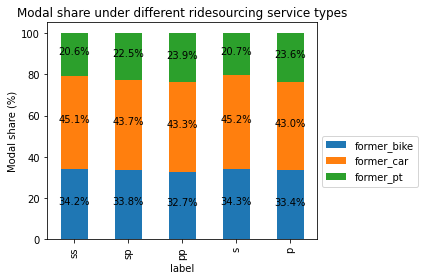

In [20]:
# Create the stacked bar chart
ax = (eql_dem[['former_bike','former_car','former_pt']]).div((eql_dem['requests_0'] + eql_dem['requests_1'].fillna(0)) / 100, axis=0).reset_index().plot(x='label', kind='bar', stacked=True,
        title='Modal share under different ridesourcing service types')

# # Label bars with their values
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fontsize=10, padding=3, labels=[f'{h:.2f}' for h in container.get_heights()])

# Label bars with their values
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, padding=3, fmt='%.1f%%')
# Show the plot
plt.ylabel('Modal share (%)')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(experiment_path,'prev-modes.png'), facecolor='w')
plt.show()


# waarom 50 procent bij requests_sh_0, requests_sh_1 en requests_mh, gaat iets fout? heeft iets met singlehoming en multihoming te maken? bars zijn ook niet helemaal gelijk?
# dit plaatje met accepts_offer kan meer zijn dan 1 omdat er ook requests worden afggewezen?
# Note: requests is niet goed als er multi-homers zijn. Bars zijn ook niet allemaal gelijk?

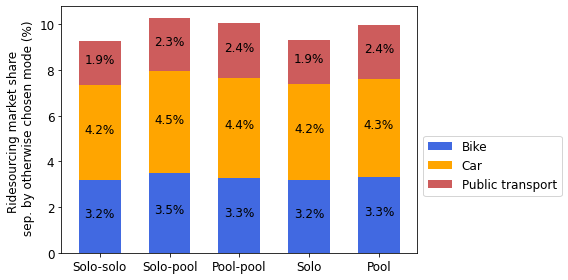

In [21]:
# Colors
# colors = ['#0076C2', '#EC6842', '#6CC24A']
colors = ['royalblue','orange','indianred']

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 4))

(eql_dem[['former_bike','former_car','former_pt']] / 100000 * 100).reset_index().plot(ax=ax, x='label', kind='bar', stacked=True, width=0.6, color=colors)

# # Label bars with their values
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fontsize=10, padding=3, labels=[f'{h:.2f}' for h in container.get_heights()])

# Label bars with their values
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fontsize=10, padding=3, fmt='%.2f')
# Show the plot

# Adjust the size of y-tick labels
ax.tick_params(axis='y', labelsize=12)  # Adjust the labelsize as needed

# Customize the labels of the bars
handles, labels = ax.get_legend_handles_labels()
ax.set_xticklabels(['Solo-solo', 'Solo-pool', 'Pool-pool', 'Solo', 'Pool'], rotation=0, size=12)
ax.set_xlabel('')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, padding=3, fmt='%.1f%%')

plt.ylabel('Ridesourcing market share \n sep. by otherwise chosen mode (%)', size=12)
plt.legend(bbox_to_anchor=(1, 0.5),handles=handles, labels=['Bike', 'Car','Public transport'],fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(experiment_path,'prev-modes.png'), facecolor='w')
plt.show()

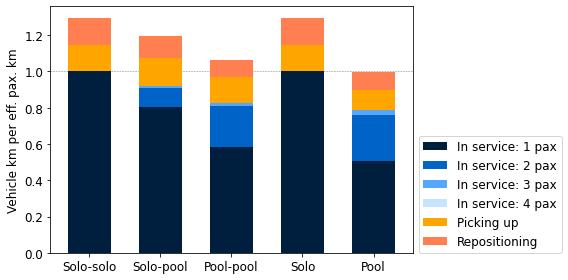

In [22]:
colors = ['#001F3F', '#0063c8', '#53a7ff', '#c8e3ff', 'orange', 'coral']  #['#001F3F', '#004080', '#0070B3', '#0090E0', 'orange', 'coral']

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 4))

(eql_sup[['km_occ_1','km_occ_2','km_occ_3','km_occ_4','pickup_dist','repos_dist']]).div((eql_dem['eff_pax_dist_0'] + eql_dem['eff_pax_dist_1'].fillna(0)) / 1000, axis=0).reset_index().plot(ax=ax, x='label', kind='bar', stacked=True,
         width=0.6, color=colors)

# # Label bars with their values
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fontsize=10, padding=3, labels=[f'{h:.2f}' for h in container.get_heights()])

# Label bars with their values
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fontsize=10, padding=3, fmt='%.2f')
# Show the plot

# horizontal line
ax.axhline(y = 1, color = 'grey', linestyle = '--', zorder=-99,linewidth=0.5) 

# Adjust the size of y-tick labels
ax.tick_params(axis='y', labelsize=12)  # Adjust the labelsize as needed

# Customize the labels of the bars
handles, labels = ax.get_legend_handles_labels()
ax.set_xticklabels(['Solo-solo', 'Solo-pool', 'Pool-pool', 'Solo', 'Pool'], rotation=0, size=12)
ax.set_xlabel('')

plt.ylabel('Vehicle km per eff. pax. km', size = 12)
plt.legend(bbox_to_anchor=(1, 0.5),handles=handles, labels=['In service: 1 pax', 'In service: 2 pax','In service: 3 pax', 'In service: 4 pax','Picking up','Repositioning'],fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(experiment_path,'veh-km.png'), facecolor='w')
plt.show()


In [23]:
eql_sup

,pickup_dist,repos_dist,km_occ_1,km_occ_0,informed,registered_0,ptcp_0,exp_inc,days_since_reg,work_exp,...,km_occ_2,km_occ_3,km_occ_4,registered_1,ptcp_1,out_1,expected_income_1,res_wage_ptcp_1,perc_inc_reg_1,res_wage_reg_1
label,,,,,,,,,,,,,,,,,,,,,
ss,7946.191176,7983.686667,54415.722805,15929.877843,2500.0,353.724314,286.345882,114.464674,140.491226,113.244526,...,NaN,NaN,NaN,232.194706,185.831176,0.925668,72.080943,28.149241,45.202477,30.026004
sp,9799.949031,7561.257280,50277.418541,17361.206311,2500.0,378.142157,300.121961,110.871507,26.616895,20.489323,...,6589.649270,524.910516,11.130733,205.799020,172.349804,0.931060,109.121020,69.155627,110.448224,71.544626
pp,8635.210826,5944.532237,35495.650041,14579.743063,2500.0,258.917647,201.752941,102.469513,35.730347,31.388694,...,13797.760903,1137.371303,22.406248,247.258824,196.588235,0.921365,102.085699,64.335752,102.849979,66.746420
s,7918.513429,8126.416749,54572.239751,16044.930178,2500.0,591.890588,476.028824,113.831429,113.121031,92.893162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p,6694.028285,6117.903507,30821.297724,12811.931792,2500.0,501.541961,388.814118,107.064302,103.578454,81.857833,...,15278.628269,1737.677854,54.470444,NaN,NaN,NaN,NaN,NaN,NaN,NaN


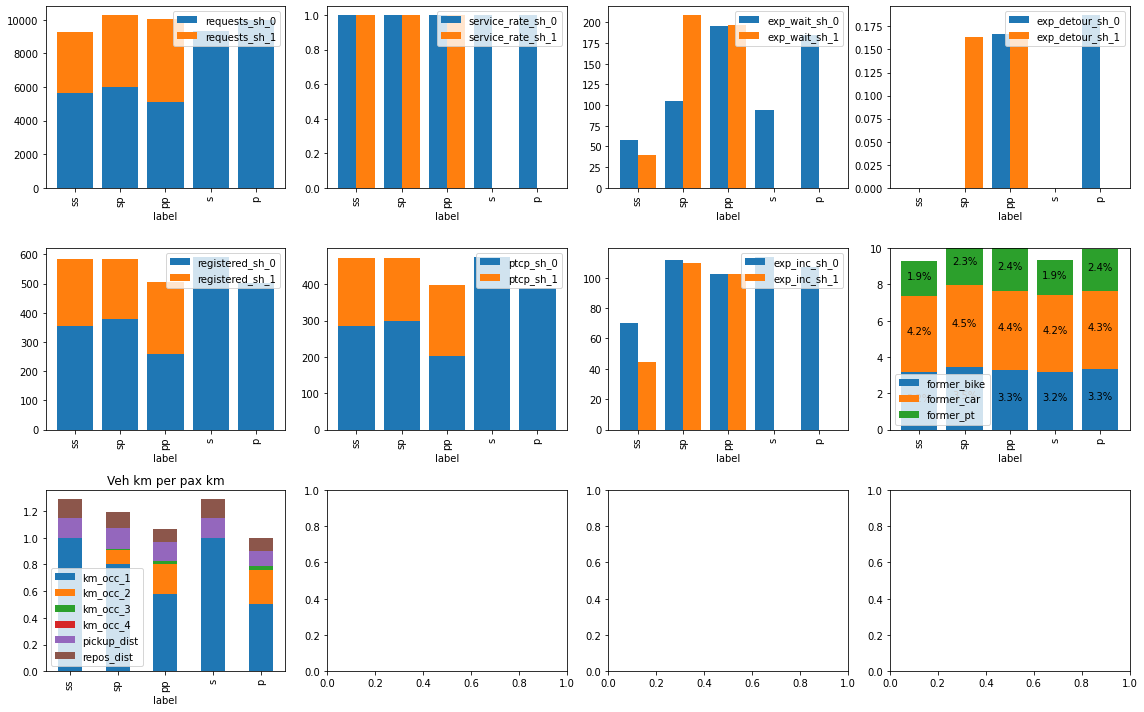

In [24]:
# Create subplots within a single figure
n_rows = 3
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))

eql_dem['service_rate_sh_0'] = eql_dem['gets_offer_sh_0'] / eql_dem['requests_sh_0']
eql_dem['service_rate_sh_1'] = eql_dem['gets_offer_sh_1'] / eql_dem['requests_sh_1']

indicators = ['requests_sh','service_rate_sh', 'exp_wait_sh', 'exp_detour_sh', 'registered_sh', 'ptcp_sh', 'exp_inc_sh']
stacked = [True, False, False, False, True, True, False]
type = ['dem', 'dem', 'dem', 'dem', 'sup', 'sup', 'sup']

i = 0
for j, indicator in enumerate(indicators):
    
    k = j - i*n_cols
        # ax.bar(height=eql_dem[indicators[j]], x=eql_dem.index.values)
    
    if type[j] == 'dem':
        if stacked[j]:
            eql_dem[['{}_0'.format(indicators[j]),'{}_1'.format(indicators[j])]].plot(kind='bar', stacked=True, ax = axes[i, k], width=0.8)
        else:
            eql_dem[['{}_0'.format(indicators[j]),'{}_1'.format(indicators[j])]].plot(kind='bar', stacked=False, ax = axes[i, k], width = 0.8)
    else:
        if stacked[j]:
            eql_sup[['{}_0'.format(indicators[j]),'{}_1'.format(indicators[j])]].plot(kind='bar', stacked=True, ax = axes[i, k], width=0.8)
        else:
            eql_sup[['{}_0'.format(indicators[j]),'{}_1'.format(indicators[j])]].plot(kind='bar', stacked=False, ax = axes[i, k], width = 0.8)
    
    ax.set_xlabel('Day')
    ax.set_ylabel(indicators[j])
    ax.set_title(f'Column: {indicators[j]}')
    ax.legend()

    if j == n_cols-1:
        i+=1


# axes[0,0].set_ylim(0,35000)
# axes[0,1].set_ylim(0,10000)

(eql_dem[['former_bike','former_car','former_pt']] / 100000 * 100).plot(kind='bar', stacked=True, ax=axes[1,3], width=0.8)
# Label bars with their values
for container in axes[1,3].containers:
    axes[1, 3].bar_label(container, label_type='center', fontsize=10, padding=3, fmt='%.1f%%')
axes[1,3].set_ylim(0,10)

(eql_sup[['km_occ_1','km_occ_2','km_occ_3','km_occ_4','pickup_dist','repos_dist']]).div((eql_dem['eff_pax_dist_0'] + eql_dem['eff_pax_dist_1'].fillna(0)) / 1000, axis=0).reset_index().plot(x='label', kind='bar', stacked=True,
        title='Veh km per pax km', ax = axes[2,0])

plt.tight_layout()
plt.savefig('Eql-dem-indicators.png', facecolor='w')

In [25]:
eql_soc

NameError: name 'eql_soc' is not defined

In [ ]:
aggr_dem.keys()

Index(['informed', 'registered_0', 'requests_0', 'gets_offer_0',
       'accepts_offer_0', 'bike', 'car', 'pt', 'time_occ_1',
       'init_perc_wait_0', 'xp_wait_0', 'corr_xp_wait_0', 'init_perc_ivt_0',
       'xp_ivt_0', 'init_perc_km_fare_0', 'xp_km_fare_0', 'informed_mh',
       'informed_sh', 'registered_mh', 'registered_sh_0', 'registered_sh_1',
       'requests_mh', 'requests_sh_0', 'requests_sh_1', 'gets_offer_mh_0',
       'gets_offer_mh_1', 'gets_offer_sh_0', 'gets_offer_sh_1',
       'accepts_offer_mh_0', 'accepts_offer_mh_1', 'exp_wait_mh',
       'exp_wait_sh_0', 'exp_wait_sh_1', 'exp_corr_wait_mh',
       'exp_corr_wait_sh_0', 'exp_corr_wait_sh_1', 'exp_detour_mh',
       'exp_detour_sh_0', 'exp_detour_sh_1', 'exp_km_fare_mh',
       'exp_km_fare_sh_0', 'exp_km_fare_sh_1', 'perc_wait_mh',
       'perc_wait_sh_0', 'perc_wait_sh_1', 'perc_detour_mh',
       'perc_detour_sh_0', 'perc_detour_sh_1', 'perc_km_fare_mh',
       'perc_km_fare_sh_0', 'perc_km_fare_sh_1', 'eff_pax_di